In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [14]:
import sys
sys.path.append('/projects/rlmolecule/pstjohn/models/20201031_bde/')
from preprocess_inputs import preprocessor as bde_preprocessor
bde_preprocessor.from_json('/projects/rlmolecule/pstjohn/models/20201031_bde/preprocessor.json')

bde_model = tf.keras.models.load_model(
    '/projects/rlmolecule/pstjohn/models/20201031_bde/',
    compile=False)

In [17]:
from rdkit import Chem

def prepare_for_bde(smiles):

    mol = Chem.MolFromSmiles(smiles)
    radical_index = None
    for i, atom in enumerate(mol.GetAtoms()):
        if atom.GetNumRadicalElectrons() != 0:
            assert radical_index == None
            is_radical = True
            radical_index = i

            atom.SetNumExplicitHs(atom.GetNumExplicitHs() + 1)
            atom.SetNumRadicalElectrons(0)
            break

    radical_rank = Chem.CanonicalRankAtoms(mol, includeChirality=True)[radical_index]

    mol_smiles = Chem.MolToSmiles(mol)
    mol = Chem.MolFromSmiles(mol_smiles)

    radical_index_reordered = list(Chem.CanonicalRankAtoms(
        mol, includeChirality=True)).index(radical_rank)

    molH = Chem.AddHs(mol)
    for bond in molH.GetAtomWithIdx(radical_index_reordered).GetBonds():
        if 'H' in {bond.GetBeginAtom().GetSymbol(), bond.GetEndAtom().GetSymbol()}:
            bond_index = bond.GetIdx()
            break
    else:
        bond_index = None
            
    return pd.Series({
        'mol_smiles': mol_smiles,
        'radical_index_mol': radical_index_reordered,
        'bond_index': bond_index
    })

@tf.function(experimental_relax_shapes=True)                
def predict(model, inputs):
    return model.predict_step(inputs)

def bde_get_inputs(smiles):
    inputs = bde_preprocessor.construct_feature_matrices(smiles, train=False)
    assert not (inputs['atom'] == 1).any() | (inputs['bond'] == 1).any()
    return {key: np.expand_dims(val, 0) for key, val in inputs.items()}

def calc_bde(smiles):
    bde_inputs = prepare_for_bde(smiles)
    inputs = bde_get_inputs(bde_inputs.mol_smiles)
    
    return predict(bde_model, inputs)[0][0, bde_inputs.bond_index, 0].numpy()

In [18]:
calc_bde('[CH2]C1=C(C(C)C)C=CCC1')

80.136566

([<matplotlib.axis.XTick at 0x7fb188b0f290>,
 [Text(0.25, 0, 'lb'), Text(0.75, 0, 'ub')])

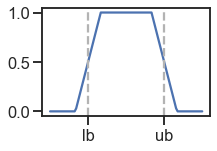

In [3]:
# def windowed_loss(target, desired_range):
#     """ Returns 0 if the molecule is in the middle of the desired range,
#     scaled loss otherwise. """
    
#     span = desired_range[1] - desired_range[0]
    
#     lower_lim = desired_range[0] + span / 6
#     upper_lim = desired_range[1] - span / 6
    
#     if target < lower_lim:
#         return max(1 - 3*(abs(target - lower_lim) / span), 0)
#     elif target > upper_lim:
#         return max(1 - 3*(abs(target - upper_lim) / span), 0)
#     else:
#         return 1

# lower_lim = .25 + .5 / 6
# upper_lim = .75 - .5 / 6

# plt.figure(figsize=(3,2))
# xs = np.linspace(0, 1, num=100)

# plt.plot(xs, [windowed_loss(x, (0.25, 0.75)) for x in xs])
# plt.axvline(.25, ls='--', color='.7')
# plt.axvline(.75, ls='--', color='.7')

# plt.xticks([.25, .75], labels=['lb', 'ub'])